## Notebook 3: Joining Data from CityBikes and POI APIs

### Section 1: Importing Libraries

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import great_circle
import sqlite3

### Section 2: Loading Data

In [4]:
# Load Part 1: Bike Stations Data
bike_stations_df = pd.read_csv('bike_stations.csv')

# Load Part 2: Combined Foursquare and Yelp POIs Data
foursquare_df = pd.read_csv('foursquare_pois.csv')
yelp_df = pd.read_csv('yelp_pois.csv')

# Add source columns
foursquare_df['source'] = 'foursquare'
yelp_df['source'] = 'yelp'

# Combine both datasets
pois_df = pd.concat([foursquare_df, yelp_df], ignore_index=True).drop_duplicates(subset='restaurant_name')

### Section 3: Finding Nearest Bike Stations for Each POI

In [5]:
# Initialize lists to hold the nearest bike station data
nearest_station_names = []
nearest_station_distances = []

# Define a function to find the nearest bike station
def find_nearest_bike_station(poi_lat, poi_lon):
    distances = bike_stations_df.apply(
        lambda row: great_circle((poi_lat, poi_lon), (row['bike_station_latitude'], row['bike_station_longitude'])).meters,
        axis=1
    )
    nearest_index = distances.idxmin()
    nearest_distance = distances.min()
    nearest_station = bike_stations_df.iloc[nearest_index]['bike_station_name']
    return nearest_station, nearest_distance

# Calculate the nearest bike station for each POI
for _, poi in pois_df.iterrows():
    nearest_station_name, nearest_station_distance = find_nearest_bike_station(poi['restaurant_latitude'], poi['restaurant_longitude'])
    nearest_station_names.append(nearest_station_name)
    nearest_station_distances.append(nearest_station_distance)

# Add the nearest bike station information to the POIs DataFrame
pois_df['nearest_bike_station'] = nearest_station_names
pois_df['distance_to_nearest_station'] = nearest_station_distances

# Join the data by merging on the nearest bike station
final_df = pd.merge(pois_df, bike_stations_df, how='inner', left_on='nearest_bike_station', right_on='bike_station_name')

# Rename columns for clarity
final_df.rename(columns={
    'restaurant_name': 'poi_name',
    'rating': 'poi_rating',
    'price': 'poi_price',
    'category': 'poi_category',
    'address': 'poi_address',
    'restaurant_latitude': 'poi_latitude',
    'restaurant_longitude': 'poi_longitude'
}, inplace=True)

### Section 4: Data Auditing

In [6]:
# Check for missing values
missing_values = final_df.isnull().sum()

# Check for duplicates
duplicates_count = final_df.duplicated().sum()

# Review data types and statistical summaries
data_types = final_df.dtypes
summary_statistics = final_df.describe(include='all')

# Print auditing results
print("### Data Auditing Results ###\n")
print("Missing Values per Column:")
print(missing_values)
print("\nTotal Duplicates:", duplicates_count)
print("\nData Types:")
print(data_types)
print("\nStatistical Summary:")
print(summary_statistics)

### Data Auditing Results ###

Missing Values per Column:
poi_name                         0
poi_latitude                     0
poi_longitude                    0
poi_rating                      26
poi_price                      244
poi_category                     0
tel                            180
poi_address                     27
distance                         0
source                           0
nearest_bike_station             0
distance_to_nearest_station      0
bike_station_name                0
bike_station_latitude            0
bike_station_longitude           0
number_of_bikes                  0
dtype: int64

Total Duplicates: 0

Data Types:
poi_name                        object
poi_latitude                   float64
poi_longitude                  float64
poi_rating                     float64
poi_price                       object
poi_category                    object
tel                             object
poi_address                     object
distance               

### Section 5: Data Cleaning

In [7]:
# Remove duplicates
final_df_clean = final_df.drop_duplicates()

# Fill missing categories with "Unknown"
final_df_clean['poi_category'] = final_df_clean['poi_category'].fillna('Unknown')

# Fill missing prices with "Unknown"
final_df_clean['poi_price'] = final_df_clean['poi_price'].fillna('Unknown')

# Fill missing address with "Unknown"
final_df_clean['poi_address'] = final_df_clean['poi_address'].fillna('Unknown')

# Remove rows where essential data like 'poi_name' or 'poi_rating' is missing
final_df_clean = final_df_clean[final_df_clean['poi_name'].notnull() & final_df_clean['poi_rating'].notnull()]

# Convert data types
# Ensure that the latitude and longitude columns are floats
final_df_clean['poi_latitude'] = final_df_clean['poi_latitude'].astype(float)
final_df_clean['poi_longitude'] = final_df_clean['poi_longitude'].astype(float)
final_df_clean['bike_station_latitude'] = final_df_clean['bike_station_latitude'].astype(float)
final_df_clean['bike_station_longitude'] = final_df_clean['bike_station_longitude'].astype(float)

# Save the cleaned DataFrame to a new CSV file
final_df_clean.to_csv('cleaned_bike_stations_pois.csv', index=False)

# Verify the cleaned data
print("\n### Data Cleaning Results ###\n")
print("Cleaned DataFrame Summary:")
print(final_df_clean.info())
print("\nMissing Values after Cleaning:")
print(final_df_clean.isnull().sum())
print("\nSample Data:")
print(final_df_clean.head())


### Data Cleaning Results ###

Cleaned DataFrame Summary:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 632
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   poi_name                     607 non-null    object 
 1   poi_latitude                 607 non-null    float64
 2   poi_longitude                607 non-null    float64
 3   poi_rating                   607 non-null    float64
 4   poi_price                    607 non-null    object 
 5   poi_category                 607 non-null    object 
 6   tel                          453 non-null    object 
 7   poi_address                  607 non-null    object 
 8   distance                     607 non-null    float64
 9   source                       607 non-null    object 
 10  nearest_bike_station         607 non-null    object 
 11  distance_to_nearest_station  607 non-null    float64
 12  bike_station_name  

### Section 6: Exploratory Data Analysis (EDA) and Visualization

#### 6.1 POI Rating vs. Number of Bikes

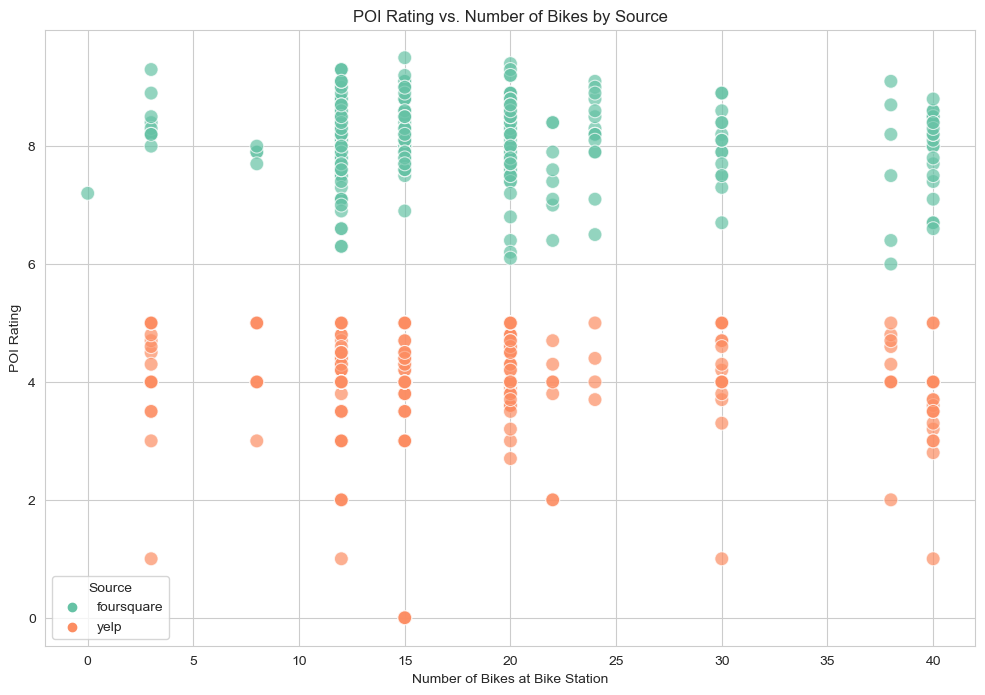

In [9]:
# Scatter plot of POI Rating vs. Number of Bikes
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=final_df_clean,
    x='number_of_bikes',
    y='poi_rating',
    hue='source',
    palette='Set2',
    s=100,
    alpha=0.7
)
plt.title('POI Rating vs. Number of Bikes by Source')
plt.xlabel('Number of Bikes at Bike Station')
plt.ylabel('POI Rating')
plt.legend(title='Source')
plt.grid(True)
plt.show()

#### 6.2 Distribution of POI Ratings by Source

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


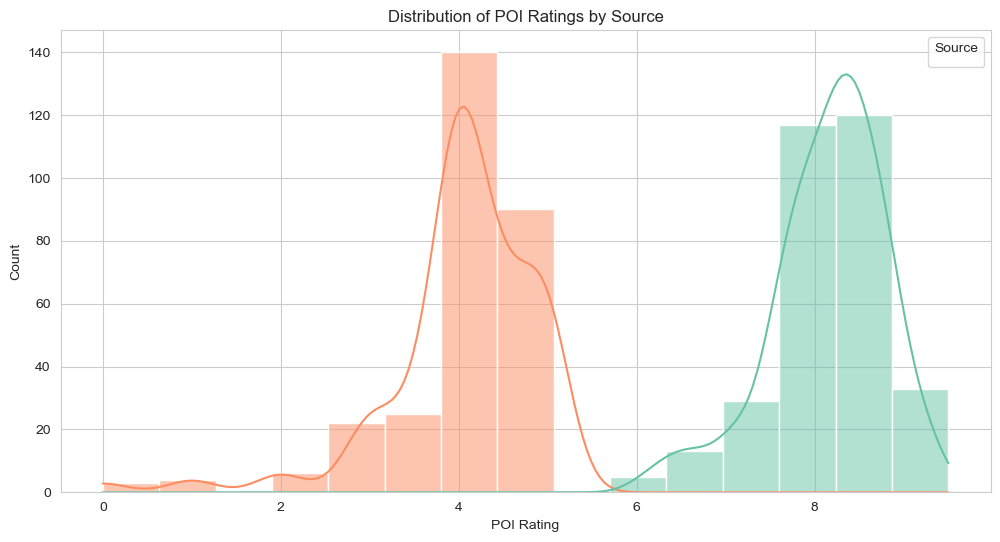

In [10]:
# Distribution of POI Ratings by Source
plt.figure(figsize=(12, 6))
sns.histplot(data=final_df_clean, x='poi_rating', hue='source', kde=True, bins=15, palette='Set2')
plt.title('Distribution of POI Ratings by Source')
plt.xlabel('POI Rating')
plt.ylabel('Count')
plt.legend(title='Source')
plt.grid(True)
plt.show()

#### 6.3 POI Price Categories by Source

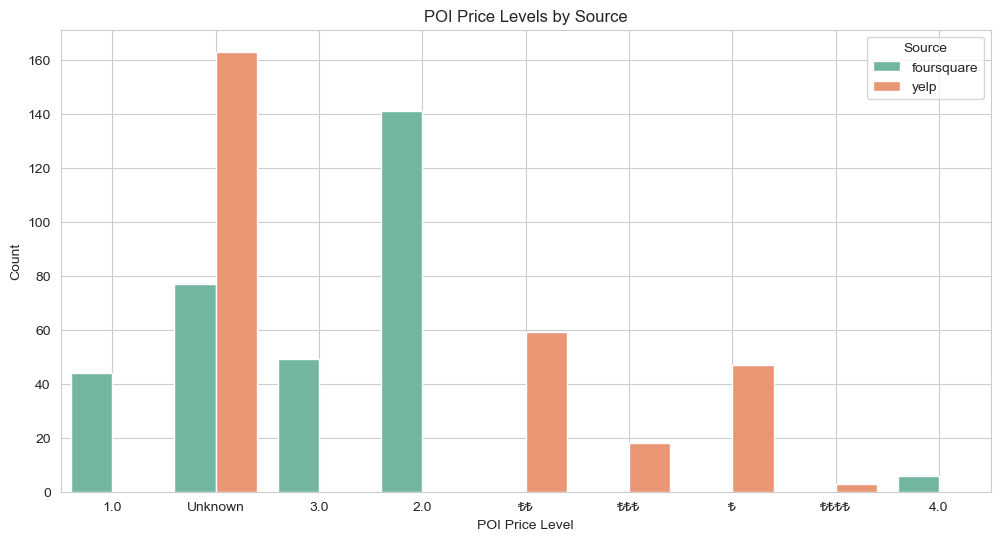

In [11]:
# Count of POI Price Levels by Source
plt.figure(figsize=(12, 6))
sns.countplot(data=final_df_clean, x='poi_price', hue='source', palette='Set2')
plt.title('POI Price Levels by Source')
plt.xlabel('POI Price Level')
plt.ylabel('Count')
plt.legend(title='Source')
plt.grid(True)
plt.show()

#### 6.4 POI Categories: Yelp vs. Foursquare

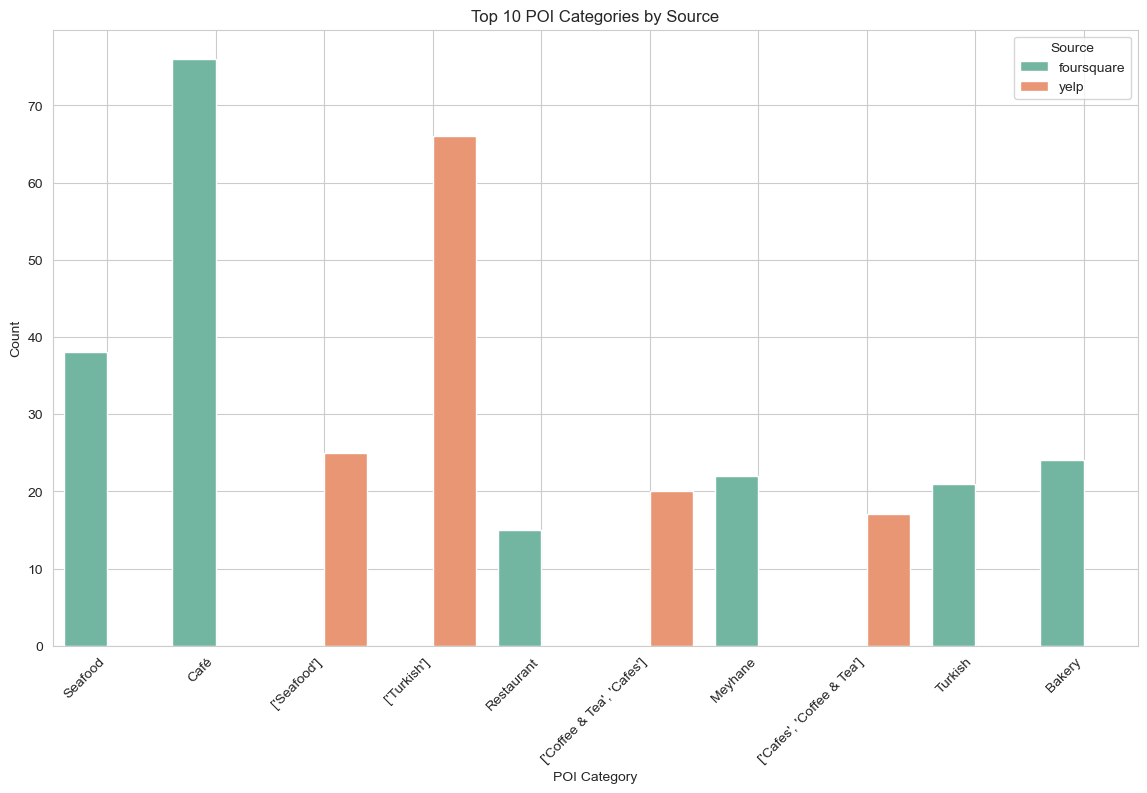

In [12]:
# Count of POI Categories by Source (Top 10 Categories)
top_categories = final_df_clean['poi_category'].value_counts().nlargest(10).index
filtered_pois_df = final_df_clean[final_df_clean['poi_category'].isin(top_categories)]

plt.figure(figsize=(14, 8))
sns.countplot(data=filtered_pois_df, x='poi_category', hue='source', dodge=True, palette='Set2')
plt.title('Top 10 POI Categories by Source')
plt.xlabel('POI Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Source')
plt.grid(True)
plt.show()

#### 6.5 Relationship Between Distance to Bike Station and POI Rating

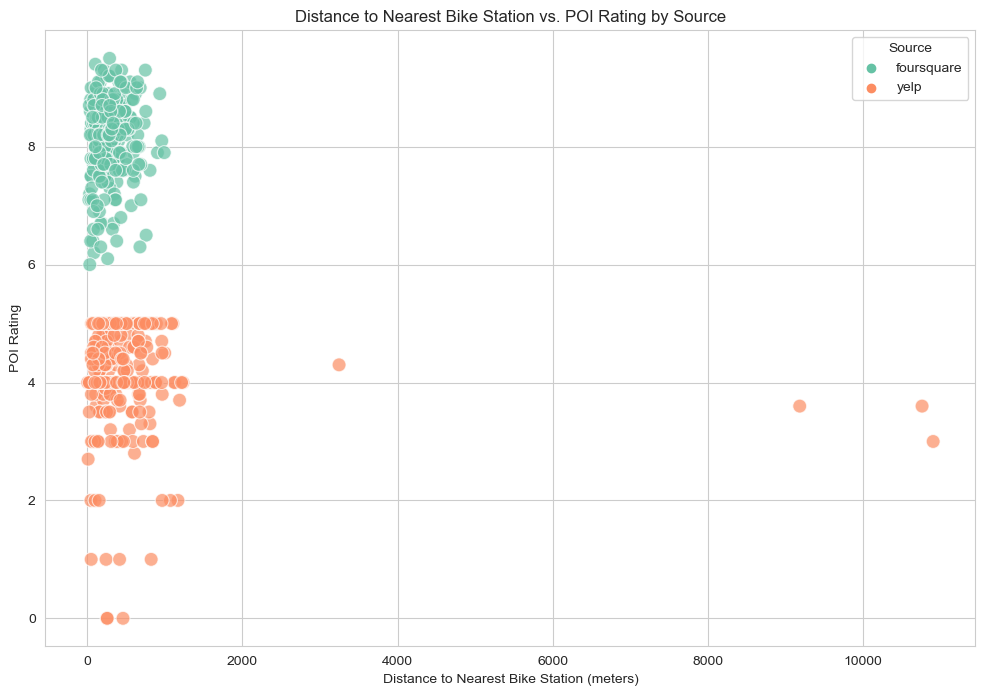

In [13]:
# Scatter plot of Distance to Nearest Bike Station vs. POI Rating
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=final_df_clean,
    x='distance_to_nearest_station',
    y='poi_rating',
    hue='source',
    palette='Set2',
    s=100,
    alpha=0.7
)
plt.title('Distance to Nearest Bike Station vs. POI Rating by Source')
plt.xlabel('Distance to Nearest Bike Station (meters)')
plt.ylabel('POI Rating')
plt.legend(title='Source')
plt.grid(True)
plt.show()

#### Section 7: SQL Database Integration

In [15]:
# Create a connection to the SQLite database
conn = sqlite3.connect('my_database.db')

# Load CSV data into Pandas DataFrames
bike_stations = pd.read_csv('bike_stations.csv')
combined_pois = pd.read_csv('combined_pois.csv')
cleaned_bike_stations_pois = pd.read_csv('cleaned_bike_stations_pois.csv')

# Write the data from the DataFrame to the SQLite database
bike_stations.to_sql('bike_stations', conn, if_exists='replace', index=False)
combined_pois.to_sql('combined_pois', conn, if_exists='replace', index=False)
cleaned_bike_stations_pois.to_sql('cleaned_bike_stations_pois', conn, if_exists='replace', index=False)

# Close the connection
conn.close()

#### Section 8: Validation of Joined Data

In [16]:
# Connect to the SQLite database
conn = sqlite3.connect('my_database.db')

# Row counts of individual tables
bike_stations_count_query = "SELECT COUNT(*) AS count FROM bike_stations;"
combined_count_query = "SELECT COUNT(*) AS count FROM combined_pois;"

bike_stations_count = pd.read_sql_query(bike_stations_count_query, conn)
combined_count = pd.read_sql_query(combined_count_query, conn)

# Join query
join_query = """
    SELECT
        bs.bike_station_name,
        bs.bike_station_latitude,
        bs.bike_station_longitude,
        bs.number_of_bikes,
        poi.restaurant_name,
        poi.rating,
        poi.price,
        poi.category,
        poi.address,
        poi.restaurant_latitude,
        poi.restaurant_longitude
    FROM combined_pois poi
    JOIN bike_stations bs
    ON ABS(bs.bike_station_latitude - poi.restaurant_latitude) < 0.01
    AND ABS(bs.bike_station_longitude - poi.restaurant_longitude) < 0.01
"""

final_joined_df = pd.read_sql_query(join_query, conn)

# Check row count after join
joined_row_count = len(final_joined_df)

# Check missing values in joined table
joined_missing_values = final_joined_df.isnull().sum()

# Print validation results
print(f"Joined Table Count: {joined_row_count}")
print("\nJoined Table Missing Values:")
print(joined_missing_values)

conn.close()

Joined Table Count: 2133

Joined Table Missing Values:
bike_station_name           0
bike_station_latitude       0
bike_station_longitude      0
number_of_bikes             0
restaurant_name             0
rating                     46
price                     746
category                    0
address                    65
restaurant_latitude         0
restaurant_longitude        0
dtype: int64


#### Section 9: Analysis of Validation Results

### Row Count Increase:
The row count increased from 634 (POIs) to 2133 in the joined table due to multiple POIs per bike station.

### Missing Data:
Some additional missing values in the price, rating, and address columns due to the join operation.